In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
import random
sys.path.append(os.path.abspath('../src'))

from data.load_data import load_images_from_folder, load_video

ImportError: cannot import name 'load_images_from_folder' from 'data.load_data' (d:\Earth\Smart-CCTV\src\data\load_data.py)

In [ ]:
# Di dalam sel notebook 01-data-exploration.ipynb

import sys
# Tambahkan path ke direktori src jika notebook ada di direktori yang berbeda
# Misal jika notebook ada di 'notebooks/' dan skrip ada di 'src/'
# sys.path.append('../src') # Jika notebook ada di dalam subfolder 'notebooks'
# sys.path.append('src') # Jika notebook ada di root dan src adalah subfolder

# Jika struktur proyek Anda adalah:
# smart-cctv/
# |-- notebooks/
# |   |-- 01-data-exploration.ipynb
# |-- src/
# |   |-- data/
# |   |   |-- load_data.py
# |   |   |-- clean_data.py
# |   |   |-- split_data.py

# Maka dari dalam notebook di `notebooks/` Anda bisa import seperti ini:
# (Anda mungkin perlu memastikan direktori 'src' dikenali sebagai package
# dengan menambahkan file __init__.py kosong di 'src/' dan 'src/data/')
# Jika tidak, cara termudah adalah dengan sys.path.append('../') agar bisa import src.data...

# Atau jika Anda menjalankan notebook dari root direktori proyek:
# sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), 'src'))) # atau cara lain yang sesuai

from data.load_data import process_loaded_data # Sesuaikan path impor jika perlu
from data.clean_data import clean_missing_values, remove_duplicates, check_file_paths_exist # dan fungsi lainnya
from data.split_data import split_data_into_sets

# --- Tahap 1: Memuat Data ---
print("--- Memuat Data ---")
raw_data_dir = "../data/raw/" # Ganti dengan path direktori data mentah Anda
annotations_file = "../data/raw/annotations.csv" # Ganti dengan path file anotasi Anda
# Pastikan path ini benar relatif terhadap lokasi notebook atau gunakan path absolut

# Periksa apakah direktori raw_data_dir ada
# import os
# if not os.path.exists(raw_data_dir):
#     print(f"Direktori data mentah TIDAK DITEMUKAN di: {os.path.abspath(raw_data_dir)}")
#     # Hentikan atau buat direktori dummy jika untuk pengujian
# else:
#    print(f"Direktori data mentah ditemukan di: {os.path.abspath(raw_data_dir)}")


# loaded_df = process_loaded_data(raw_data_path=raw_data_dir, annotation_file_path=annotations_file)
# print("\nData yang berhasil dimuat:")
# print(loaded_df.head())
# print(f"Jumlah baris data yang dimuat: {len(loaded_df)}")
# print("-" * 30)

# --- Contoh Data Dummy untuk pengujian jika data asli belum siap ---
print("Menggunakan data dummy untuk demonstrasi...")
dummy_video_paths = [f'../data/raw/vid{i}.mp4' for i in range(10)]
dummy_annotations = {
    'filename': [f'vid{i}.mp4' for i in range(10)],
    'label_perilaku': [random.choice(['normal', 'aneh', 'berbahaya']) for _ in range(10)],
    'durasi_detik': [random.randint(5, 60) for _ in range(10)]
}
# Buat file dummy jika belum ada (hanya untuk pengujian)
# for p in dummy_video_paths:
#    os.makedirs(os.path.dirname(p), exist_ok=True)
#    if not os.path.exists(p): open(p, 'a').close() # Buat file kosong
# if not os.path.exists(annotations_file):
#    pd.DataFrame(dummy_annotations).to_csv(annotations_file, index=False)
#    print(f"File anotasi dummy dibuat di {annotations_file}")

# Muat data dummy (atau data asli jika sudah siap)
loaded_df = process_loaded_data(raw_data_path=raw_data_dir, annotation_file_path=annotations_file)

if not loaded_df.empty:
    print("\nData yang berhasil dimuat (atau dummy):")
    print(loaded_df.head())
    print(f"Jumlah baris data yang dimuat: {len(loaded_df)}")
else:
    print("Tidak ada data yang dimuat, periksa path dan fungsi load_data.")
print("-" * 30)


# --- Tahap 2: Membersihkan Data ---
if not loaded_df.empty:
    print("--- Membersihkan Data ---")
    # Pastikan kolom 'video_path' ada sebelum membersihkan
    if 'video_path' not in loaded_df.columns and not loaded_df.empty:
        print("Peringatan: Kolom 'video_path' tidak ada di loaded_df. Langkah pembersihan yang bergantung padanya mungkin gagal.")
        # Jika menggunakan data dummy tanpa membuat file fisik, check_file_paths_exist akan menghapus semua baris
        # loaded_df['video_path'] = loaded_df['filename'].apply(lambda x: os.path.join(raw_data_dir, x))


    # Jika menggunakan dummy data dan tidak membuat file fisik, fungsi ini akan menghapus semua data.
    # Untuk demo, kita bisa menonaktifkannya atau memastikan file dummy dibuat.
    # cleaned_df = check_file_paths_exist(loaded_df, path_column='video_path')
    cleaned_df = loaded_df.copy() # Lewati check_file_paths_exist untuk demo dummy tanpa file fisik

    if 'label_perilaku' in cleaned_df.columns: # Ganti dengan nama kolom label Anda
        cleaned_df = clean_missing_values(cleaned_df, columns_to_check=['label_perilaku'])
    else:
        cleaned_df = clean_missing_values(cleaned_df) # Periksa semua kolom jika label_perilaku tidak ada
    
    cleaned_df = remove_duplicates(cleaned_df, subset_cols=['filename']) # Ganti 'filename' jika ada ID unik lain
    
    # Contoh filter: hanya ambil video dengan durasi > 10 detik jika kolomnya ada
    if 'durasi_detik' in cleaned_df.columns:
         cleaned_df = filter_data_by_condition(cleaned_df, 'durasi_detik', 10, operator=">")

    print("\nData setelah dibersihkan:")
    print(cleaned_df.head())
    print(f"Jumlah baris data bersih: {len(cleaned_df)}")
    print("-" * 30)
else:
    print("Tidak ada data untuk dibersihkan.")
    cleaned_df = pd.DataFrame()


# --- Tahap 3: Membagi Data ---
if not cleaned_df.empty:
    print("--- Membagi Data ---")
    # Ganti 'label_perilaku' dengan nama kolom target Anda jika ingin stratifikasi
    stratify_column_name = 'label_perilaku' if 'label_perilaku' in cleaned_df.columns else None 
    
    train_df, val_df, test_df = split_data_into_sets(
        cleaned_df, 
        test_size=0.2, 
        val_size=0.15, # Proporsi dari keseluruhan data
        random_state=42, 
        stratify_col=stratify_column_name
    )

    print("\nUkuran masing-masing set:")
    print(f"  Set Latih: {len(train_df)}")
    print(f"  Set Validasi: {len(val_df)}")
    print(f"  Set Uji: {len(test_df)}")

    # Tampilkan beberapa baris dari setiap set
    print("\nContoh data latih:")
    print(train_df.head())
    print("-" * 30)
else:
    print("Tidak ada data bersih untuk dibagi.")

# Di sini Anda bisa melanjutkan dengan eksplorasi data menggunakan train_df, val_df, test_df

In [2]:
folder_path = '../data/raw/mobil'
images = load_images_from_folder(folder_path)
print(f"Jumlah gambar mobil yang dimuat: {len(images)}")

# Memuat video mobil
video_path = '../data/raw/video30.mp4'
frames = load_video(video_path)
print(f"Jumlah frame dalam video: {len(frames)}")

Jumlah gambar mobil yang dimuat: 153
Jumlah frame dalam video: 1805


In [ ]:
# Extract data dan rezize (224px) dari video

save_dir_224 = "../data/raw/frames_224"
save_dir_original = "../data/raw/frames_original"

os.makedirs(save_dir_224, exist_ok=True)
os.makedirs(save_dir_original, exist_ok=True)

for i, frame in enumerate(frames):
    if i % 5 == 0:  # hanya simpan setiap 5 frame
        # Simpan versi resize 224x224
        resized = cv2.resize(frame, (224, 224))
        filename_224 = os.path.join(save_dir_224, f"car{i}.jpg")
        cv2.imwrite(filename_224, resized)
        print(f"Saved resized frame: {filename_224}")

        # Simpan versi original
        filename_original = os.path.join(save_dir_original, f"car{i}.jpg")
        cv2.imwrite(filename_original, frame)
        print(f"Saved original frame: {filename_original}")

Saved resized frame: ../data/raw/frames_224\car0.jpg
Saved original frame: ../data/raw/frames_original\car0.jpg
Saved resized frame: ../data/raw/frames_224\car5.jpg
Saved original frame: ../data/raw/frames_original\car5.jpg
Saved resized frame: ../data/raw/frames_224\car10.jpg
Saved original frame: ../data/raw/frames_original\car10.jpg
Saved resized frame: ../data/raw/frames_224\car15.jpg
Saved original frame: ../data/raw/frames_original\car15.jpg
Saved resized frame: ../data/raw/frames_224\car20.jpg
Saved original frame: ../data/raw/frames_original\car20.jpg
Saved resized frame: ../data/raw/frames_224\car25.jpg
Saved original frame: ../data/raw/frames_original\car25.jpg
Saved resized frame: ../data/raw/frames_224\car30.jpg
Saved original frame: ../data/raw/frames_original\car30.jpg
Saved resized frame: ../data/raw/frames_224\car35.jpg
Saved original frame: ../data/raw/frames_original\car35.jpg
Saved resized frame: ../data/raw/frames_224\car40.jpg
Saved original frame: ../data/raw/fram

In [ ]:
# cek dimensi shape pada folder / gambar
folder_path = "../data/raw/frames_224"
frames = load_images_from_folder(folder_path)

for i, frame in enumerate(frames):
    print(f"Frame {i}: shape = {frame.shape}")  # e.g., (480, 640, 3)

Frame 0: shape = (224, 224, 3)
Frame 1: shape = (224, 224, 3)
Frame 2: shape = (224, 224, 3)
Frame 3: shape = (224, 224, 3)
Frame 4: shape = (224, 224, 3)
Frame 5: shape = (224, 224, 3)
Frame 6: shape = (224, 224, 3)
Frame 7: shape = (224, 224, 3)
Frame 8: shape = (224, 224, 3)
Frame 9: shape = (224, 224, 3)
Frame 10: shape = (224, 224, 3)
Frame 11: shape = (224, 224, 3)
Frame 12: shape = (224, 224, 3)
Frame 13: shape = (224, 224, 3)
Frame 14: shape = (224, 224, 3)
Frame 15: shape = (224, 224, 3)
Frame 16: shape = (224, 224, 3)
Frame 17: shape = (224, 224, 3)
Frame 18: shape = (224, 224, 3)
Frame 19: shape = (224, 224, 3)
Frame 20: shape = (224, 224, 3)
Frame 21: shape = (224, 224, 3)
Frame 22: shape = (224, 224, 3)
Frame 23: shape = (224, 224, 3)
Frame 24: shape = (224, 224, 3)
Frame 25: shape = (224, 224, 3)
Frame 26: shape = (224, 224, 3)
Frame 27: shape = (224, 224, 3)
Frame 28: shape = (224, 224, 3)
Frame 29: shape = (224, 224, 3)
Frame 30: shape = (224, 224, 3)
Frame 31: shape = 

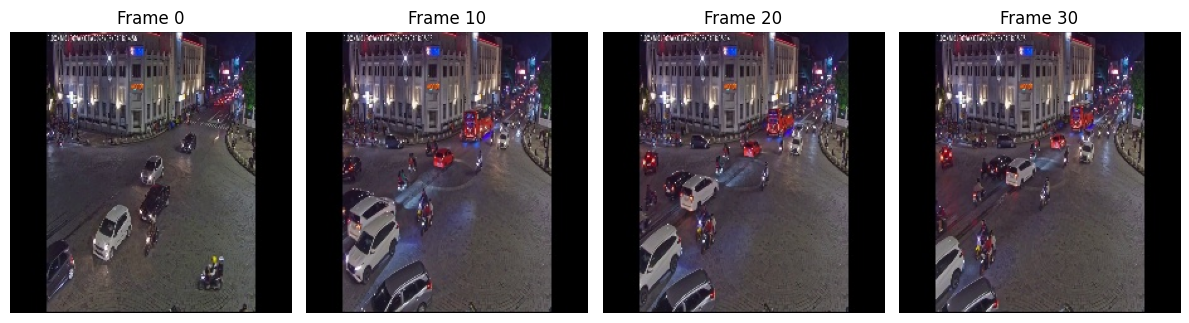

In [ ]:

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(cv2.cvtColor(frames[i*10], cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {i*10}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [23]:
gray_dir = "../data/raw/frames_gray"
gray224_dir = "../data/raw/frames_gray_224"

os.makedirs(gray_dir, exist_ok=True)
os.makedirs(gray224_dir, exist_ok=True)

# Loop simpan tiap 5 frame
for i, frame in enumerate(frames):
    if i % 5 == 0:
        # Convert ke grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Simpan grayscale original
        gray_path = os.path.join(gray_dir, f"car{i}.jpg")
        cv2.imwrite(gray_path, gray)

        # Resize grayscale ke 224x224
        gray_resized = cv2.resize(gray, (224, 224))
        gray224_path = os.path.join(gray224_dir, f"car{i}.jpg")
        cv2.imwrite(gray224_path, gray_resized)

        print(f"Saved: Gray={gray_path}, Gray224={gray224_path}")

Saved: Gray=../data/raw/frames_gray\car0.jpg, Gray224=../data/raw/frames_gray_224\car0.jpg
Saved: Gray=../data/raw/frames_gray\car5.jpg, Gray224=../data/raw/frames_gray_224\car5.jpg
Saved: Gray=../data/raw/frames_gray\car10.jpg, Gray224=../data/raw/frames_gray_224\car10.jpg
Saved: Gray=../data/raw/frames_gray\car15.jpg, Gray224=../data/raw/frames_gray_224\car15.jpg
Saved: Gray=../data/raw/frames_gray\car20.jpg, Gray224=../data/raw/frames_gray_224\car20.jpg
Saved: Gray=../data/raw/frames_gray\car25.jpg, Gray224=../data/raw/frames_gray_224\car25.jpg
Saved: Gray=../data/raw/frames_gray\car30.jpg, Gray224=../data/raw/frames_gray_224\car30.jpg
Saved: Gray=../data/raw/frames_gray\car35.jpg, Gray224=../data/raw/frames_gray_224\car35.jpg
Saved: Gray=../data/raw/frames_gray\car40.jpg, Gray224=../data/raw/frames_gray_224\car40.jpg
Saved: Gray=../data/raw/frames_gray\car45.jpg, Gray224=../data/raw/frames_gray_224\car45.jpg
Saved: Gray=../data/raw/frames_gray\car50.jpg, Gray224=../data/raw/frames_

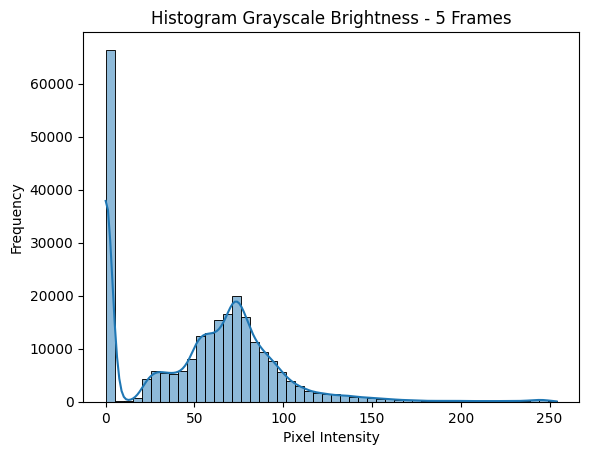

In [ ]:

all_gray_pixels = []

# Ambil 5 frame pertama (atau sebanyak mungkin jika < 5)
num_frames = min(5, len(frames))

for i in range(num_frames):
    gray = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
    all_gray_pixels.extend(gray.ravel())

# Plot histogram gabungan
sns.histplot(all_gray_pixels, bins=50, kde=True)
plt.title(f"Histogram Grayscale Brightness - {num_frames} Frames")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


Frame 0 is clear (Variance: 3257.84)
Frame 10 is clear (Variance: 3687.18)
Frame 20 is clear (Variance: 3705.35)
Frame 30 is clear (Variance: 3497.09)
Frame 40 is clear (Variance: 3422.81)
Frame 50 is clear (Variance: 3363.25)
Frame 60 is clear (Variance: 3206.56)
Frame 70 is clear (Variance: 3291.55)
Frame 80 is clear (Variance: 3447.43)
Frame 90 is clear (Variance: 3189.21)
Frame 100 is clear (Variance: 3389.73)
Frame 110 is clear (Variance: 3311.13)
Frame 120 is clear (Variance: 3395.52)
Frame 130 is clear (Variance: 3504.10)
Frame 140 is clear (Variance: 3216.56)
Frame 150 is clear (Variance: 3062.55)
Frame 160 is clear (Variance: 2950.23)
Frame 170 is clear (Variance: 2950.04)
Frame 180 is clear (Variance: 2888.27)
Frame 190 is clear (Variance: 3210.05)
Frame 200 is clear (Variance: 3213.40)
Frame 210 is clear (Variance: 3197.01)
Frame 220 is clear (Variance: 3205.30)
Frame 230 is clear (Variance: 3127.96)
Frame 240 is clear (Variance: 3234.45)
Frame 250 is clear (Variance: 3258.0

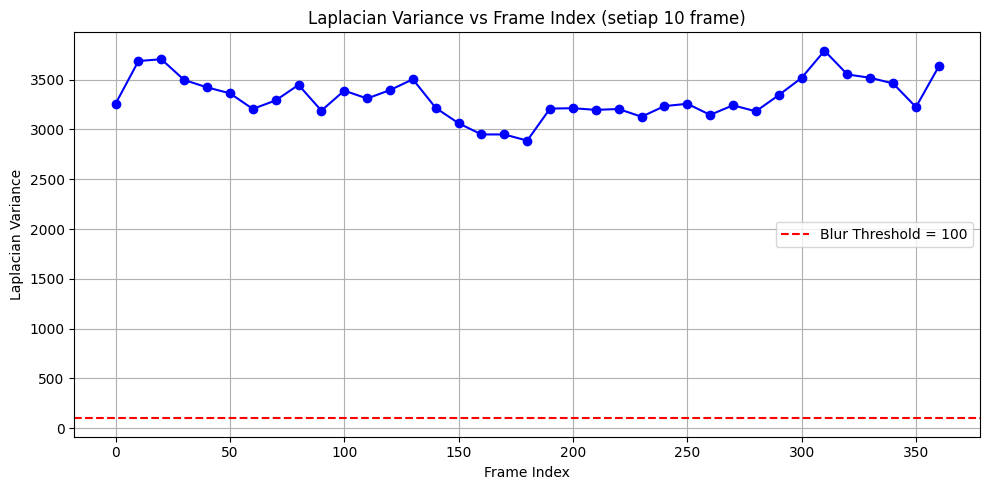

In [14]:
def is_blurry(image, threshold=100.0):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    variance = cv2.Laplacian(gray, cv2.CV_64F).var()
    return variance < threshold, variance

variances = []
frame_indices = []

for i in range(0, len(frames), 10):
    blur, var = is_blurry(frames[i])
    variances.append(var)
    frame_indices.append(i)
    print(f"Frame {i} is {'blurry' if blur else 'clear'} (Variance: {var:.2f})")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(frame_indices, variances, marker='o', linestyle='-', color='blue')
plt.axhline(100, color='red', linestyle='--', label='Blur Threshold = 100')
plt.title('Laplacian Variance vs Frame Index (setiap 10 frame)')
plt.xlabel('Frame Index')
plt.ylabel('Laplacian Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
import os
import cv2
import numpy as np
# from tensorflow import keras
# from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
# from keras_preprocessing.image import ImageDataGenerator


# Folder input
frame_dir = "../data/raw/frames_original"
frames = load_images_from_folder(frame_dir)

# Folder output
base_dir = "../data/preprocessed"
rgb_dir = os.path.join(base_dir, "original_rgb")
norm_dir = os.path.join(base_dir, "normalized")
edge_dir = os.path.join(base_dir, "edged")
aug_dir = os.path.join(base_dir, "augmented")  # opsional
gray_dir = os.path.join(base_dir, "grayscale")

os.makedirs(rgb_dir, exist_ok=True)
os.makedirs(norm_dir, exist_ok=True)
os.makedirs(edge_dir, exist_ok=True)
os.makedirs(aug_dir, exist_ok=True)
os.makedirs(gray_dir, exist_ok=True)

# Data augmentasi (keras)
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)

# Loop frame
for i, frame in enumerate(frames):
    if i % 5 != 0:
        continue  # hanya setiap kelipatan 5

    resized = cv2.resize(frame, (224, 224))

    # 1. Simpan RGB asli
    cv2.imwrite(os.path.join(rgb_dir, f"frame_{i}.jpg"), resized)

    # 2. Normalisasi (0–1), simpan dalam bentuk uint8 agar bisa dilihat
    normalized = resized.astype("float32") / 255.0
    normalized_uint8 = (normalized * 255).astype("uint8")
    cv2.imwrite(os.path.join(norm_dir, f"frame_{i}.jpg"), normalized_uint8)

    # 3. Edge Detection (Canny)
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    cv2.imwrite(os.path.join(edge_dir, f"frame_{i}.jpg"), edges)

    # 4. Augmentasi (opsional, hanya 2 gambar)
    x = resized.reshape((1, *resized.shape))
    gen = datagen.flow(x, batch_size=1)
    for j in range(2):  # ambil 2 augmentasi
        aug = next(gen)[0].astype("uint8")
        cv2.imwrite(os.path.join(aug_dir, f"frame_{i}_aug{j}.jpg"), aug)
    
    # 5. Grayscale
    gray_resized = cv2.resize(gray, (224, 224))
    gray224_path = os.path.join(gray_dir, f"car{i}.jpg")
    cv2.imwrite(gray224_path, gray_resized)
    
    print(f"Frame {i} processed.")


ModuleNotFoundError: No module named 'keras_preprocessing'